# SPICE simulation using Python

## Agenda

1. Motivation 
2. Comparison PySpice vs. ahkab
    * Butterworth Filter in NgSpice
    * Butterworth Filter in ahkab
3. Handson & examples
    * P2 - Advanced Butterworth Filter analysis (ahkab)
    * P3 - Transient simulation of a Colpitts oscillator (ahkab)
    * P4 - Small-signal transfer function of an opamp integrator (ahkab)
    * P5 - Basic OpAmp AC-simulation (NgSpice)
    * P6 - CMOS-Ring Oscillator (NgSpice)

## Motivation 

* Develop in a familiar environment

* Tons of Libraries for post-processing

* Large community

* Inexpensive

* (Automatic) generation and verification of schematics 



 
   
   

## PySpice 
  + Frontend for ngspice 
  + Mature open source simulator in the background
  + Easy to simulate external spice (i.e from KiCad)
  + Good integration into python
    + all data-types derive from numpy
  - ngspice need to be compiled on each computer
  

In [22]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Parser import SpiceParser
from PySpice.Unit import *

## ahkab
  + based on numpy
  + easy to distripute to simulation to multiple machines
  + Not very mature 
  + Not lots of device libraries available
      

In [23]:
from ahkab import new_ac, new_op, new_tran, run
from ahkab.circuit import Circuit
from ahkab.plotting import plot_results # calls matplotlib for you
from ahkab import printing, time_functions

## Butterworth Filter (ahkab)



### Schematic
![Butterworth Filter](./pictures/butterworth_dp.svg)

In [24]:
%matplotlib inline
import os

# print(os.environ['PATH'])

import numpy as np
from scipy.fftpack import fft

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from ahkab import new_ac, new_op, new_tran, run
from ahkab.circuit import Circuit
from ahkab.plotting import plot_results # calls matplotlib for you
from ahkab import printing, time_functions
import numpy as np

In [26]:
# Create circuit element
cir = Circuit(title="Butterworth Low-pass filter")

gnd = cir.get_ground_node()

# Add voltage source
voltage_step = time_functions.pulse(v1=0, v2=1, td=500e-9, tr=1e-12, pw=1, tf=1e-12, per=2)
cir.add_vsource("V1", n1="n1", n2=gnd, dc_value=5, ac_value=1, function=voltage_step)

# Define circuit
cir.add_resistor("R1", n1="n1", n2="n2", value=600)
cir.add_inductor("L1", n1="n2", n2="n3", value=15.24e-3)
cir.add_capacitor("C1", n1="n3", n2=gnd, value=119.37e-9)
cir.add_inductor("L2", n1="n3", n2="n4", value=61.86e-3)
cir.add_capacitor("C2", n1="n4", n2=gnd, value=155.12e-9)
cir.add_resistor("R2", n1="n4", n2=gnd, value=1.2e3)

# Define the analysis
ac1 = new_ac(1e3, 1.0e4, 1e2, x0=None)

# run the simulation
res = run(cir, ac1)


In [28]:
#Print spice netlist
print(cir)

#play with results:
print(res['ac'].keys())
print(res['ac']['Vn4'][0:10])

* Butterworth Low-pass filter
V1 n1 0 type=vdc value=5 vac=1 type=pulse v1=0 v2=1 td=5e-07 per=2 tr=1e-12 tf=1e-12 pw=1
R1 n1 n2 600
L1 n2 n3 0.01524
C1 n3 0 1.1937e-07
L2 n3 n4 0.06186
C2 n4 0 1.5512e-07
R2 n4 0 1200
['f', 'Vn1', 'Vn2', 'Vn3', 'Vn4', 'I(V1)', 'I(L1)', 'I(L2)']
[ 0.37208075-0.55303142j  0.35864368-0.56181176j  0.34462391-0.57048744j
  0.32999935-0.57903234j  0.31474750-0.58741781j  0.29884546-0.59561235j
  0.28227007-0.60358139j  0.26499796-0.61128697j  0.24700572-0.61868739j
  0.22827007-0.62573684j]


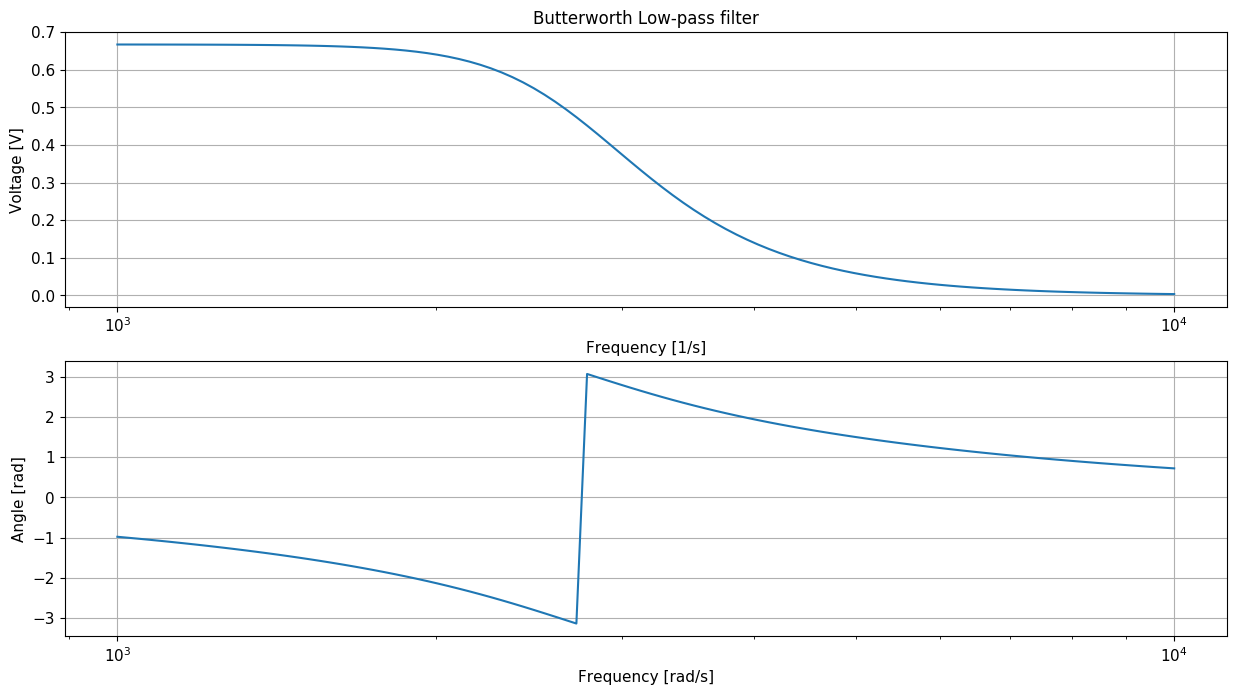

In [15]:
# Plot:
figure = plt.figure(figsize=[15,8],dpi=100)
axe = plt.subplot(211)
axe.set_title('Butterworth Low-pass filter')
axe.set_xlabel('Frequency [1/s]')
axe.set_ylabel('Voltage [V]')
#plt.grid(True)
axe.semilogx(res['ac']['f'], np.abs(res['ac']['Vn4']), '-')
axe.grid(True)
axe = plt.subplot(212)
axe.semilogx(res['ac']['f'], np.angle(res['ac']['Vn4']), '-')
axe.set_xlabel('Frequency [rad/s]')
axe.set_ylabel('Angle [rad]')
axe.grid(True)

In [16]:
ak_dat = res['ac']['Vn4']
ak_f = res['ac']['f']

## Butterworth Filter (NgSpice)

In [17]:
%matplotlib inline
import os

# print(os.environ['PATH'])

import numpy as np
from scipy.fftpack import fft

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Parser import SpiceParser
from PySpice.Unit import *

In [18]:
# Create circuit element
cir = Circuit("Butterworth Low-pass filter")

# Add voltage source
cir.Sinusoidal('V1', 'n1', cir.gnd, amplitude=1@u_V)

# Define circuit
cir.R(1, 'n1', 'n2', 600)
cir.L(1, 'n2', 'n3', 15.24e-3)
cir.C(1, 'n3', cir.gnd, nano(119.37))
cir.L(2, 'n3', 'n4', 61.86e-3)
cir.C(2, 'n4', cir.gnd, nano(155.12))
cir.R(2, 'n4', cir.gnd, kilo(1.2))

# Define the analysis and run the simulation
simulator = cir.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=1@u_kHz, stop_frequency=10@u_kHz, number_of_points=100,  variation='dec')


In [19]:
print(str(cir))
#print(analysis.nodes)
#x = analysis['n4']
#print(x.tolist()[0:10])

.title Butterworth Low-pass filter
VV1 n1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
R1 n1 n2 600
L1 n2 n3 0.01524
C1 n3 0 119.37n
L2 n3 n4 0.06186
C2 n4 0 155.12n
R2 n4 0 1.2k



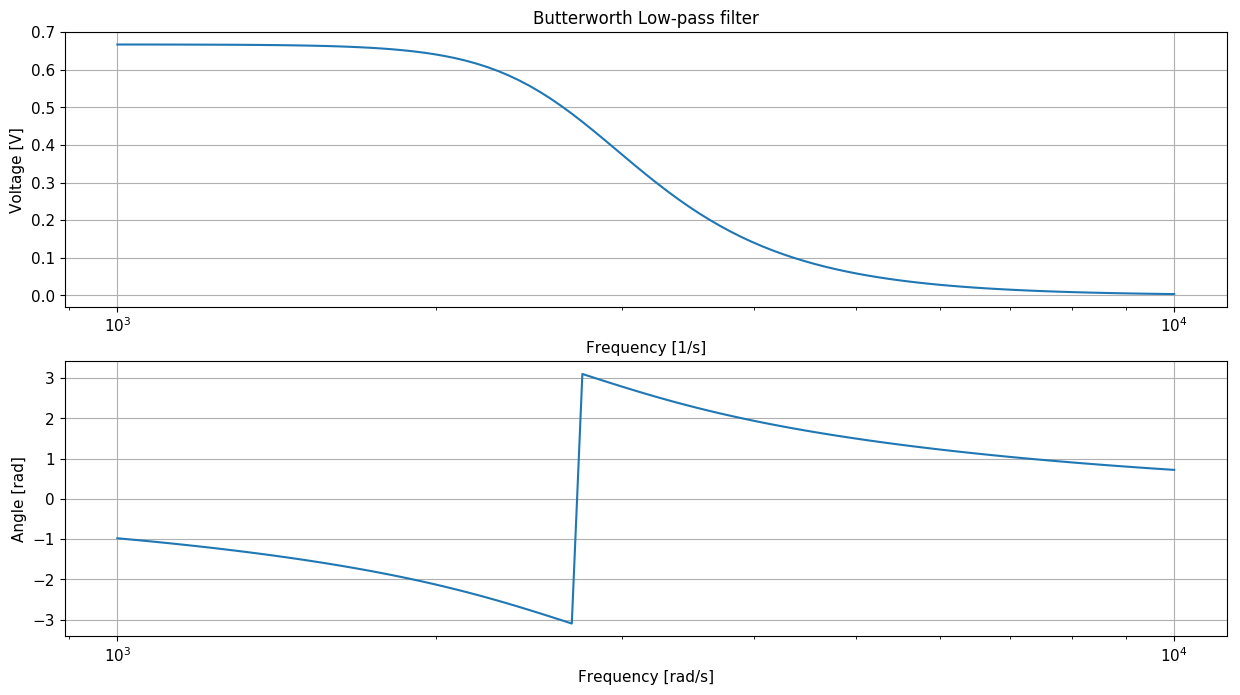

In [20]:
# Plot:
figure = plt.figure(figsize=[15,8],dpi=100)
axe = plt.subplot(211)
axe.set_title('Butterworth Low-pass filter')
axe.set_xlabel('Frequency [1/s]')
axe.set_ylabel('Voltage [V]')
#plt.grid(True)
axe.semilogx(analysis.frequency, np.abs(analysis['n4']), '-')
axe.grid(True)
axe = plt.subplot(212)
axe.semilogx(analysis.frequency, np.angle(analysis['n4']), '-')
axe.set_xlabel('Frequency [rad/s]')
axe.set_ylabel('Angle [rad]')
axe.grid(True)

In [21]:
# ak_dat = res['ac']['Vn4']
# ak_f = res['ac']['f']
prin
np.abs(analysis['n4'])/(np.abs(analysis['n4'])+np.abs(ak_dat))

ValueError: operands could not be broadcast together with shapes (101,) (100,) 